In [1]:
import pandas as pd
import numpy as np
df_location = '/content/drive/MyDrive/Weather/41.9N_12.46E.csv'
df = pd.read_csv(df_location)
df.columns = ['year', 'month', 'day', 'hour', 'temperature', 'precipitation', 'u-wind', 'v-wind']
df.temperature = df.temperature -273.15

df['date'] = pd.to_datetime(df[['year', 'month', 'day', 'hour']])
df['wind'] = (df['u-wind']**2 + df['v-wind']**2)**0.5
# Constants for transformations
hours_in_day = 24
days_in_month = 30
months_in_year = 12

# Add cyclical features
df['hour_sin'] = np.sin(2 * np.pi * df['date'].dt.hour / hours_in_day)
df['hour_cos'] = np.cos(2 * np.pi * df['date'].dt.hour / hours_in_day)
df['day_sin'] = np.sin(2 * np.pi * df['date'].dt.day / days_in_month)
df['day_cos'] = np.cos(2 * np.pi * df['date'].dt.day / days_in_month)
df['month_sin'] = np.sin(2 * np.pi * df['date'].dt.month / months_in_year)
df['month_cos'] = np.cos(2 * np.pi * df['date'].dt.month / months_in_year)

columns_to_drop = ['month','day','hour','date']
df = df.drop(columns=[col for col in columns_to_drop if col in df.columns], axis=1)
df

,year,temperature,precipitation,u-wind,v-wind,wind,hour_sin,hour_cos,day_sin,day_cos,month_sin,month_cos
0,1980,10.92,1.771900e-05,5.0144,-8.4435,9.820229,0.258819,0.965926,0.207912,0.978148,5.000000e-01,0.866025
1,1980,11.01,1.958600e-05,4.9712,-7.7456,9.203649,0.500000,0.866025,0.207912,0.978148,5.000000e-01,0.866025
2,1980,11.05,9.337800e-07,4.5916,-7.5101,8.802522,0.707107,0.707107,0.207912,0.978148,5.000000e-01,0.866025
3,1980,10.99,1.958600e-05,4.4404,-7.1360,8.404740,0.866025,0.500000,0.207912,0.978148,5.000000e-01,0.866025
4,1980,10.93,5.875300e-05,4.6318,-6.5412,8.015040,0.965926,0.258819,0.207912,0.978148,5.000000e-01,0.866025
...,...,...,...,...,...,...,...,...,...,...,...,...
341874,2018,14.18,0.000000e+00,-1.3146,-3.9372,4.150869,-0.965926,0.258819,0.207912,0.978148,-2.449294e-16,1.000000
341875,2018,13.80,0.000000e+00,-2.1201,-4.0275,4.551437,-0.866025,0.500000,0.207912,0.978148,-2.449294e-16,1.000000
341876,2018,13.30,0.000000e+00,-2.7930,-4.4435,5.248385,-0.707107,0.707107,0.207912,0.978148,-2.449294e-16,1.000000
341877,2018,13.28,0.000000e+00,-3.0675,-5.7936,6.555559,-0.500000,0.866025,0.207912,0.978148,-2.449294e-16,1.000000


In [2]:
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import pandas as pd

TARGET_COLUMN = 'temperature'

# split data
df_filtered = df.tail(4*7 * 24)
df_train = df_filtered.iloc[:-24]  # First 7 days
df_test = df_filtered.iloc[-24:]  # Last day

X_train = df_train.drop(TARGET_COLUMN, axis=1)
y_train = df_train[TARGET_COLUMN]
X_test = df_test.drop(TARGET_COLUMN, axis=1)
y_test = df_test[TARGET_COLUMN]


# scale X data
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

X_train = pd.DataFrame(X_train)
y_train = pd.DataFrame(y_train)
X_test = pd.DataFrame(X_test)
y_test = pd.DataFrame(y_test)

X_train = X_train.reset_index(drop=True)
X_test = X_test.reset_index(drop=True)
y_train = y_train.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)


In [3]:
metrics_df = pd.DataFrame(columns=[
    'MODEL', 'MAE', 'MSE', 'RMSE', 'MAPE', 'MDAPE', 'R2', 'Training_Length', 'Testing_Length'
])

In [7]:
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import Ridge, Lasso
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

import time
import numpy as np
import pandas as pd

# linear regression model
linear_model = LinearRegression()
start_time_lm = time.time()
linear_model.fit(X_train, y_train)
end_time_lm = time.time()
training_time_lm = end_time_lm - start_time_lm
y_pred_lm = linear_model.predict(X_test)

mae_lm = mean_absolute_error(y_test, y_pred_lm)
mse_lm = mean_squared_error(y_test, y_pred_lm)
rmse_lm = np.sqrt(mse_lm)
mape_lm = np.mean(np.abs((y_test - y_pred_lm) / y_test)) * 100
mdape_lm = np.median(np.abs((y_test - y_pred_lm) / y_test)) * 100
r2_lm = r2_score(y_test, y_pred_lm)

metrics_df = metrics_df._append({
    'MODEL': 'Linear Regression',
    'MAE': mae_lm,
    'MSE': mse_lm,
    'RMSE': rmse_lm,
    'MAPE': mape_lm,
    'MDAPE': mdape_lm,
    'R2': r2_lm,
    'Training_Length': len(y_train),
    'Testing_Length': len(y_test),
    'Training_Time': training_time_lm
}, ignore_index=True)


decision_tree_model = DecisionTreeRegressor()
start_time_dt = time.time()
decision_tree_model.fit(X_train, y_train)
end_time_dt = time.time()
training_time_dt = end_time_dt - start_time_dt
# Decision Tree model
y_pred_dt = decision_tree_model.predict(X_test)
# Decision Tree Metrics
mae_dt = mean_absolute_error(y_test, y_pred_dt)
mse_dt = mean_squared_error(y_test, y_pred_dt)
rmse_dt = np.sqrt(mse_dt)
mape_dt = np.mean(np.abs((y_test.values - y_pred_dt) / y_test.values)) * 100
mdape_dt = np.median(np.abs((y_test.values - y_pred_dt) / y_test.values)) * 100
r2_dt = r2_score(y_test, y_pred_dt)

# Append metrics
metrics_df = metrics_df._append({
    'MODEL': 'Decision Tree',
    'MAE': mae_dt,
    'MSE': mse_dt,
    'RMSE': rmse_dt,
    'MAPE': mape_dt,
    'MDAPE': mdape_dt,
    'R2': r2_dt,
    'Training_Length': len(y_train),
    'Testing_Length': len(y_test),
    'Training_Time': training_time_dt
}, ignore_index=True)





# Random Forest model
#random_forest_model = RandomForestRegressor()
random_forest_model = RandomForestRegressor(n_estimators = 10, criterion = 'squared_error',
                       max_depth = None, min_samples_split = 2, min_samples_leaf = 1,
                       n_jobs = None, random_state = None,
                       verbose = 0, warm_start = False, ccp_alpha = 0.0, max_samples = None
                       )
start_time_rf = time.time()
random_forest_model.fit(X_train, y_train)
end_time_rf = time.time()
training_time_rf = end_time_rf - start_time_rf

y_pred_rf = random_forest_model.predict(X_test)

# Random Forest metrics
mae_rf = mean_absolute_error(y_test, y_pred_rf)
mse_rf = mean_squared_error(y_test, y_pred_rf)
rmse_rf = np.sqrt(mse_rf)
mape_rf = np.mean(np.abs((y_test.values - y_pred_rf) / y_test.values)) * 100
mdape_rf = np.median(np.abs((y_test.values - y_pred_rf) / y_test.values)) * 100
r2_rf = r2_score(y_test, y_pred_rf)

# Append metrics
metrics_df = metrics_df._append({
    'MODEL': 'Random Forest',
    'MAE': mae_rf,
    'MSE': mse_rf,
    'RMSE': rmse_rf,
    'MAPE': mape_rf,
    'MDAPE': mdape_rf,
    'R2': r2_rf,
    'Training_Length': len(y_train),
    'Testing_Length': len(y_test),
    'Training_Time': training_time_rf
}, ignore_index=True)


gradient_boosting_model = GradientBoostingRegressor()
start_time = time.time()
gradient_boosting_model.fit(X_train, y_train)
end_time = time.time()
training_time_gb = end_time - start_time

y_pred_gb = gradient_boosting_model.predict(X_test)

# Gradient Boosting metrics
mae_gb = mean_absolute_error(y_test, y_pred_gb)
mse_gb = mean_squared_error(y_test, y_pred_gb)
rmse_gb = np.sqrt(mse_gb)
mape_gb = np.mean(np.abs((y_test.values - y_pred_gb) / y_test.values)) * 100
mdape_gb = np.median(np.abs((y_test.values - y_pred_gb) / y_test.values)) * 100
r2_gb = r2_score(y_test, y_pred_gb)

metrics_df = metrics_df._append({
    'MODEL': 'Gradient Boosting',
    'MAE': mae_gb,
    'MSE': mse_gb,
    'RMSE': rmse_gb,
    'MAPE': mape_gb,
    'MDAPE': mdape_gb,
    'R2': r2_gb,
    'Training_Length': len(y_train),
    'Testing_Length': len(y_test),
    'Training_Time': training_time_gb
}, ignore_index=True)



# XGBoost Model
start_time_xg = time.time()
xgboost_model = XGBRegressor()
xgboost_model.fit(X_train, y_train)
end_time_xg = time.time()
training_time_xg = end_time_xg - start_time_xg

y_pred_xg = xgboost_model.predict(X_test)

mae_xg = mean_absolute_error(y_test, y_pred_xg)
mse_xg = mean_squared_error(y_test, y_pred_xg)
rmse_xg = np.sqrt(mse_xg)
mape_xg = np.mean(np.abs((y_test.values - y_pred_xg) / y_test.values)) * 100
mdape_xg = np.median(np.abs((y_test.values - y_pred_xg) / y_test.values)) * 100
r2_xg = r2_score(y_test, y_pred_xg)

metrics_df = metrics_df._append({
    'MODEL': 'XGBoost',
    'MAE': mae_xg,
    'MSE': mse_xg,
    'RMSE': rmse_xg,
    'MAPE': mape_xg,
    'MDAPE': mdape_xg,
    'R2': r2_xg,
    'Training_Length': len(y_train),
    'Testing_Length': len(y_test),
    'Training_Time': training_time_xg
}, ignore_index=True)

print(metrics_df)

<ipython-input-7-fb472c3c4884>:86: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  random_forest_model.fit(X_train, y_train)
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [8]:
print(metrics_df)

               MODEL       MAE       MSE      RMSE       MAPE      MDAPE  \
0  Linear Regression  0.738118  0.603878  0.777096   5.508551   4.984586   
1      Decision Tree  0.953333  1.176250  1.084551   7.141432   6.603577   
2      Random Forest  0.977250  1.168067  1.080771   8.024374   7.487377   
3  Gradient Boosting  0.476206  0.287705  0.536381   6.154869   5.258491   
4            XGBoost  2.010722  4.136822  2.033918  15.230754  15.305201   

         R2 Training_Length Testing_Length  Training_Time  
0 -0.114492             648             24       0.004886  
1 -1.170838             648             24       0.007650  
2 -1.155735             648             24       0.033237  
3  0.469025             648             24       0.137758  
4 -6.634746             648             24       5.274654  


In [ ]:
# Plotting
plt.figure(figsize=(10, 6))
plt.plot(y_test, label='Actual Values', color='blue')
plt.plot(y_pred_lm, label='Predicted Values', color='red')
plt.title('Actual vs Predicted Values')
plt.xlabel('Sample Index')
plt.ylabel(TARGET_COLUMN)
plt.legend()
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(y_test, label='Actual Values', color='blue')
plt.plot(y_pred_dt, label='Predicted Values', color='red')
plt.title('Actual vs Predicted Values')
plt.xlabel('Sample Index')
plt.ylabel(TARGET_COLUMN)
plt.legend()
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(y_test, label='Actual Values', color='blue')
plt.plot(y_pred_rf, label='Predicted Values', color='red')
plt.title('Actual vs Predicted Values')
plt.xlabel('Sample Index')
plt.ylabel(TARGET_COLUMN)
plt.legend()
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(y_test, label='Actual Values', color='blue')
plt.plot(y_pred_gb, label='Predicted Values', color='red')
plt.title('Actual vs Predicted Values')
plt.xlabel('Sample Index')
plt.ylabel(TARGET_COLUMN)
plt.legend()
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(y_test, label='Actual Values', color='blue')
plt.plot(y_pred_xg, label='Predicted Values', color='red')
plt.title('Actual vs Predicted Values')
plt.xlabel('Sample Index')
plt.ylabel(TARGET_COLUMN)
plt.legend()
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(y_test, label='Actual Values', color='blue')
plt.plot(y_pred_rnn, label='Predicted Values', color='red')
plt.title('Actual vs Predicted Values')
plt.xlabel('Sample Index')
plt.ylabel(TARGET_COLUMN)
plt.legend()
plt.show()


In [27]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense

# Number of features in your input
n_features = X_train.shape[1]

# Define the RNN model
model = Sequential()
model.add(SimpleRNN(50, activation='relu', return_sequences=True, input_shape=(n_features, 1)))
model.add(SimpleRNN(50, activation='relu'))
model.add(Dense(1))

model.compile(optimizer='adam', loss='mean_squared_error')

# Convert the DataFrame to NumPy array and reshape
X_train_array = X_train.to_numpy().reshape((X_train.shape[0], X_train.shape[1], 1))
X_test_array = X_test.to_numpy().reshape((X_test.shape[0], X_test.shape[1], 1))
y_train_array = y_train.to_numpy()
y_test_array = y_test.to_numpy()

start_time_rnn = time.time()
model.fit(X_train_array, y_train_array, epochs=100, batch_size=32, verbose=1)
end_time_rnn = time.time()
training_time_rnn = end_time_rnn - start_time_rnn

# Predict
y_pred_rnn = model.predict(X_test_array)

# Calculate the metrics for RNN
mae_rnn = mean_absolute_error(y_test_array, y_pred_rnn)
mse_rnn = mean_squared_error(y_test_array, y_pred_rnn)
rmse_rnn = np.sqrt(mse_rnn)
mape_rnn = np.mean(np.abs((y_test_array - y_pred_rnn) / y_test_array)) * 100
mdape_rnn = np.median(np.abs((y_test_array - y_pred_rnn) / y_test_array)) * 100
r2_rnn = r2_score(y_test_array, y_pred_rnn)

# Append metrics to the DataFrame
metrics_df = metrics_df._append({
    'MODEL': 'RNN',
    'MAE': mae_rnn,
    'MSE': mse_rnn,
    'RMSE': rmse_rnn,
    'MAPE': mape_rnn,
    'MDAPE': mdape_rnn,
    'R2': r2_rnn,
    'Training_Length': len(y_train_array),
    'Testing_Length': len(y_test_array),
    'Training_Time': training_time_rnn  # Ensure you have calculated training_time_rnn
}, ignore_index=True)

print(metrics_df)





Epoch 1/100
21/21 [==============================] - 2s 14ms/step - loss: 161.5422
Epoch 2/100
21/21 [==============================] - 0s 16ms/step - loss: 23.1965
Epoch 3/100
21/21 [==============================] - 0s 15ms/step - loss: 7.0708
Epoch 4/100
21/21 [==============================] - 0s 16ms/step - loss: 4.6772
Epoch 5/100
21/21 [==============================] - 0s 15ms/step - loss: 4.1028
Epoch 6/100
21/21 [==============================] - 0s 14ms/step - loss: 3.8664
Epoch 7/100
21/21 [==============================] - 0s 16ms/step - loss: 3.3430
Epoch 8/100
21/21 [==============================] - 0s 16ms/step - loss: 2.9604
Epoch 9/100
21/21 [==============================] - 0s 16ms/step - loss: 2.3841
Epoch 10/100
21/21 [==============================] - 0s 16ms/step - loss: 2.1550
Epoch 11/100
21/21 [==============================] - 0s 15ms/step - loss: 1.9565
Epoch 12/100
21/21 [==============================] - 0s 15ms/step - loss: 1.8142
Epoch 13/100
21/21 [==

1/1 [==============================] - 0s 223ms/step
               MODEL       MAE       MSE      RMSE       MAPE      MDAPE  \
0  Linear Regression  0.738118  0.603878  0.777096   5.508551   4.984586   
1      Decision Tree  0.953333  1.176250  1.084551   7.141432   6.603577   
2      Random Forest  0.977250  1.168067  1.080771   8.024374   7.487377   
3  Gradient Boosting  0.476206  0.287705  0.536381   6.154869   5.258491   
4            XGBoost  2.010722  4.136822  2.033918  15.230754  15.305201   
5                RNN  0.230552  0.064449  0.253868   1.713285   1.764463   
6                RNN  0.436532  0.274851  0.524263   3.311078   2.654768   
7                RNN  0.637668  0.500448  0.707424   4.655668   4.767175   
8                RNN  0.221040  0.074830  0.273551   1.647594   1.309810   

         R2 Training_Length Testing_Length  Training_Time  
0 -0.114492             648             24       0.004886  
1 -1.170838             648             24       0.007650  
2 -1.1

In [26]:
!pip install keras-tuner

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense
from keras_tuner import BayesianOptimization
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

def build_model(hp):
    model = Sequential()
    model.add(SimpleRNN(
        units=hp.Int('units', min_value=30, max_value=100, step=10),
        activation='relu',
        return_sequences=True,
        input_shape=(X_train.shape[1], 1))
    )
    model.add(SimpleRNN(
        units=hp.Int('units', min_value=30, max_value=100, step=10),
        activation='relu')
    )
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

# Convert the DataFrame to NumPy array and reshape
X_train_array = X_train.to_numpy().reshape((X_train.shape[0], X_train.shape[1], 1))
X_test_array = X_test.to_numpy().reshape((X_test.shape[0], X_test.shape[1], 1))
y_train_array = y_train.to_numpy()
y_test_array = y_test.to_numpy()

# Initialize the BayesianOptimization tuner
tuner = BayesianOptimization(
    build_model,
    objective='val_loss',
    max_trials=30,
    executions_per_trial=2,
    directory='my_dir',
    project_name='hyperparam_tuning'
    )

tuner.search(X_train_array, y_train_array, epochs=100, validation_split=0.2, verbose=1, callbacks=[early_stopping])

# Get the optimal hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

# Build the model with the best hyperparameters and train it
model = tuner.hypermodel.build(best_hps)
start_time_rnn = time.time()
model.fit(X_train_array, y_train_array, epochs=100, batch_size=32, verbose=1, callbacks=[early_stopping])
end_time_rnn = time.time()
training_time_rnn = end_time_rnn - start_time_rnn

# Predict
y_pred_rnn = model.predict(X_test_array)

# Calculate the metrics for RNN
mae_rnn = mean_absolute_error(y_test_array, y_pred_rnn)
mse_rnn = mean_squared_error(y_test_array, y_pred_rnn)
rmse_rnn = np.sqrt(mse_rnn)
mape_rnn = np.mean(np.abs((y_test_array - y_pred_rnn) / y_test_array)) * 100
mdape_rnn = np.median(np.abs((y_test_array - y_pred_rnn) / y_test_array)) * 100
r2_rnn = r2_score(y_test_array, y_pred_rnn)

# Append metrics to the DataFrame
metrics_df = metrics_df._append({
    'MODEL': 'RNN',
    'MAE': mae_rnn,
    'MSE': mse_rnn,
    'RMSE': rmse_rnn,
    'MAPE': mape_rnn,
    'MDAPE': mdape_rnn,
    'R2': r2_rnn,
    'Training_Length': len(y_train_array),
    'Testing_Length': len(y_test_array),
    'Training_Time': training_time_rnn
}, ignore_index=True)

print(metrics_df)


Trial 68 Complete [00h 00m 16s]
val_loss: 1.0705606341362

Best val_loss So Far: 0.5338453650474548
Total elapsed time: 00h 15m 38s
Epoch 1/100
21/21 [==============================] - ETA: 0s - loss: 81.7272

21/21 [==============================] - 2s 15ms/step - loss: 81.7272
Epoch 2/100
20/21 [===========================>..] - ETA: 0s - loss: 9.6977 

21/21 [==============================] - 0s 15ms/step - loss: 9.6545
Epoch 3/100
21/21 [==============================] - ETA: 0s - loss: 5.4903

21/21 [==============================] - 0s 14ms/step - loss: 5.4903
Epoch 4/100
21/21 [==============================] - ETA: 0s - loss: 4.9527

21/21 [==============================] - 0s 14ms/step - loss: 4.9527
Epoch 5/100
21/21 [==============================] - ETA: 0s - loss: 4.2746

21/21 [==============================] - 0s 15ms/step - loss: 4.2746
Epoch 6/100
21/21 [==============================] - ETA: 0s - loss: 3.6797

21/21 [==============================] - 0s 15ms/step - loss: 3.6797
Epoch 7/100
21/21 [==============================] - ETA: 0s - loss: 2.7652

21/21 [==============================] - 0s 14ms/step - loss: 2.7652
Epoch 8/100
20/21 [===========================>..] - ETA: 0s - loss: 2.2599

21/21 [==============================] - 0s 15ms/step - loss: 2.2896
Epoch 9/100
20/21 [===========================>..] - ETA: 0s - loss: 2.3915

21/21 [==============================] - 0s 16ms/step - loss: 2.3992
Epoch 10/100
21/21 [==============================] - ETA: 0s - loss: 2.1098

21/21 [==============================] - 0s 15ms/step - loss: 2.1098
Epoch 11/100
21/21 [==============================] - ETA: 0s - loss: 2.0093

21/21 [==============================] - 0s 15ms/step - loss: 2.0093
Epoch 12/100
20/21 [===========================>..] - ETA: 0s - loss: 1.9629

21/21 [==============================] - 0s 16ms/step - loss: 1.9665
Epoch 13/100
21/21 [==============================] - ETA: 0s - loss: 1.9332

21/21 [==============================] - 0s 15ms/step - loss: 1.9332
Epoch 14/100
21/21 [==============================] - ETA: 0s - loss: 1.8978

21/21 [==============================] - 0s 14ms/step - loss: 1.8978
Epoch 15/100
21/21 [==============================] - ETA: 0s - loss: 1.7795

21/21 [==============================] - 0s 15ms/step - loss: 1.7795
Epoch 16/100
21/21 [==============================] - ETA: 0s - loss: 1.7924

21/21 [==============================] - 0s 14ms/step - loss: 1.7924
Epoch 17/100
21/21 [==============================] - ETA: 0s - loss: 1.9690

21/21 [==============================] - 0s 15ms/step - loss: 1.9690
Epoch 18/100
20/21 [===========================>..] - ETA: 0s - loss: 1.8527

21/21 [==============================] - 0s 15ms/step - loss: 1.8516
Epoch 19/100
21/21 [==============================] - ETA: 0s - loss: 2.0310

21/21 [==============================] - 0s 14ms/step - loss: 2.0310
Epoch 20/100
21/21 [==============================] - ETA: 0s - loss: 1.6248

21/21 [==============================] - 0s 14ms/step - loss: 1.6248
Epoch 21/100
18/21 [========================>.....] - ETA: 0s - loss: 1.5500

21/21 [==============================] - 0s 14ms/step - loss: 1.5500
Epoch 22/100
18/21 [========================>.....] - ETA: 0s - loss: 1.5481

21/21 [==============================] - 0s 14ms/step - loss: 1.5553
Epoch 23/100
21/21 [==============================] - ETA: 0s - loss: 1.4941

21/21 [==============================] - 0s 14ms/step - loss: 1.4941
Epoch 24/100
21/21 [==============================] - ETA: 0s - loss: 1.2696

21/21 [==============================] - 0s 14ms/step - loss: 1.2696
Epoch 25/100
21/21 [==============================] - ETA: 0s - loss: 1.2858

21/21 [==============================] - 0s 15ms/step - loss: 1.2858
Epoch 26/100
21/21 [==============================] - ETA: 0s - loss: 1.2026

21/21 [==============================] - 0s 15ms/step - loss: 1.2026
Epoch 27/100
21/21 [==============================] - ETA: 0s - loss: 1.0728

21/21 [==============================] - 0s 14ms/step - loss: 1.0728
Epoch 28/100
21/21 [==============================] - ETA: 0s - loss: 1.0497

21/21 [==============================] - 0s 15ms/step - loss: 1.0497
Epoch 29/100
21/21 [==============================] - ETA: 0s - loss: 0.9825

21/21 [==============================] - 0s 15ms/step - loss: 0.9825
Epoch 30/100
21/21 [==============================] - ETA: 0s - loss: 0.9507

21/21 [==============================] - 0s 14ms/step - loss: 0.9507
Epoch 31/100
21/21 [==============================] - ETA: 0s - loss: 0.7736

21/21 [==============================] - 0s 14ms/step - loss: 0.7736
Epoch 32/100
21/21 [==============================] - ETA: 0s - loss: 0.7788

21/21 [==============================] - 0s 15ms/step - loss: 0.7788
Epoch 33/100
21/21 [==============================] - ETA: 0s - loss: 0.6674

21/21 [==============================] - 0s 14ms/step - loss: 0.6674
Epoch 34/100
21/21 [==============================] - ETA: 0s - loss: 0.6535

21/21 [==============================] - 0s 14ms/step - loss: 0.6535
Epoch 35/100
20/21 [===========================>..] - ETA: 0s - loss: 0.7036

21/21 [==============================] - 0s 15ms/step - loss: 0.7015
Epoch 36/100
21/21 [==============================] - ETA: 0s - loss: 0.6574

21/21 [==============================] - 0s 14ms/step - loss: 0.6574
Epoch 37/100
21/21 [==============================] - ETA: 0s - loss: 0.6179

21/21 [==============================] - 0s 14ms/step - loss: 0.6179
Epoch 38/100
21/21 [==============================] - ETA: 0s - loss: 0.7333

21/21 [==============================] - 0s 14ms/step - loss: 0.7333
Epoch 39/100
21/21 [==============================] - ETA: 0s - loss: 0.6906

21/21 [==============================] - 0s 14ms/step - loss: 0.6906
Epoch 40/100
21/21 [==============================] - ETA: 0s - loss: 0.6933

21/21 [==============================] - 0s 14ms/step - loss: 0.6933
Epoch 41/100
21/21 [==============================] - ETA: 0s - loss: 0.6249

21/21 [==============================] - 0s 14ms/step - loss: 0.6249
Epoch 42/100
21/21 [==============================] - ETA: 0s - loss: 0.5512

21/21 [==============================] - 0s 14ms/step - loss: 0.5512
Epoch 43/100
21/21 [==============================] - ETA: 0s - loss: 0.4952

21/21 [==============================] - 0s 13ms/step - loss: 0.4952
Epoch 44/100
18/21 [========================>.....] - ETA: 0s - loss: 0.5861

21/21 [==============================] - 0s 13ms/step - loss: 0.6106
Epoch 45/100
21/21 [==============================] - ETA: 0s - loss: 0.7454

21/21 [==============================] - 0s 14ms/step - loss: 0.7454
Epoch 46/100
20/21 [===========================>..] - ETA: 0s - loss: 0.5496

21/21 [==============================] - 0s 14ms/step - loss: 0.5498
Epoch 47/100
21/21 [==============================] - ETA: 0s - loss: 0.6291

21/21 [==============================] - 0s 14ms/step - loss: 0.6291
Epoch 48/100
21/21 [==============================] - ETA: 0s - loss: 0.4520

21/21 [==============================] - 0s 14ms/step - loss: 0.4520
Epoch 49/100
21/21 [==============================] - ETA: 0s - loss: 0.4855

21/21 [==============================] - 0s 14ms/step - loss: 0.4855
Epoch 50/100
21/21 [==============================] - ETA: 0s - loss: 0.5218

21/21 [==============================] - 0s 14ms/step - loss: 0.5218
Epoch 51/100
19/21 [==========================>...] - ETA: 0s - loss: 0.4152

21/21 [==============================] - 0s 13ms/step - loss: 0.4278
Epoch 52/100
18/21 [========================>.....] - ETA: 0s - loss: 0.4191

21/21 [==============================] - 0s 14ms/step - loss: 0.4123
Epoch 53/100
21/21 [==============================] - ETA: 0s - loss: 0.4249

21/21 [==============================] - 0s 14ms/step - loss: 0.4249
Epoch 54/100
21/21 [==============================] - ETA: 0s - loss: 0.4271

21/21 [==============================] - 0s 14ms/step - loss: 0.4271
Epoch 55/100
21/21 [==============================] - ETA: 0s - loss: 0.4180

21/21 [==============================] - 0s 14ms/step - loss: 0.4180
Epoch 56/100
20/21 [===========================>..] - ETA: 0s - loss: 0.5462

21/21 [==============================] - 0s 15ms/step - loss: 0.5427
Epoch 57/100
21/21 [==============================] - ETA: 0s - loss: 0.3600

21/21 [==============================] - 0s 15ms/step - loss: 0.3600
Epoch 58/100
21/21 [==============================] - ETA: 0s - loss: 0.3829

21/21 [==============================] - 0s 15ms/step - loss: 0.3829
Epoch 59/100
18/21 [========================>.....] - ETA: 0s - loss: 0.3274

21/21 [==============================] - 0s 14ms/step - loss: 0.3187
Epoch 60/100
21/21 [==============================] - ETA: 0s - loss: 0.3158

21/21 [==============================] - 0s 15ms/step - loss: 0.3158
Epoch 61/100
21/21 [==============================] - ETA: 0s - loss: 0.3984

21/21 [==============================] - 0s 15ms/step - loss: 0.3984
Epoch 62/100
21/21 [==============================] - ETA: 0s - loss: 0.3399

21/21 [==============================] - 0s 15ms/step - loss: 0.3399
Epoch 63/100
21/21 [==============================] - ETA: 0s - loss: 0.3117

21/21 [==============================] - 0s 15ms/step - loss: 0.3117
Epoch 64/100
21/21 [==============================] - ETA: 0s - loss: 0.3553

21/21 [==============================] - 0s 15ms/step - loss: 0.3553
Epoch 65/100
19/21 [==========================>...] - ETA: 0s - loss: 0.3470

21/21 [==============================] - 0s 15ms/step - loss: 0.3452
Epoch 66/100
20/21 [===========================>..] - ETA: 0s - loss: 0.3401

21/21 [==============================] - 0s 16ms/step - loss: 0.3412
Epoch 67/100
21/21 [==============================] - ETA: 0s - loss: 0.3023

21/21 [==============================] - 0s 15ms/step - loss: 0.3023
Epoch 68/100
21/21 [==============================] - ETA: 0s - loss: 0.2730

21/21 [==============================] - 0s 17ms/step - loss: 0.2730
Epoch 69/100
21/21 [==============================] - ETA: 0s - loss: 0.4167

21/21 [==============================] - 0s 15ms/step - loss: 0.4167
Epoch 70/100
19/21 [==========================>...] - ETA: 0s - loss: 0.3427

21/21 [==============================] - 0s 16ms/step - loss: 0.3346
Epoch 71/100
18/21 [========================>.....] - ETA: 0s - loss: 0.3100

21/21 [==============================] - 0s 16ms/step - loss: 0.3029
Epoch 72/100
20/21 [===========================>..] - ETA: 0s - loss: 0.3168

21/21 [==============================] - 0s 15ms/step - loss: 0.3165
Epoch 73/100
21/21 [==============================] - ETA: 0s - loss: 0.3897

21/21 [==============================] - 0s 14ms/step - loss: 0.3897
Epoch 74/100
21/21 [==============================] - ETA: 0s - loss: 0.2740

21/21 [==============================] - 0s 15ms/step - loss: 0.2740
Epoch 75/100
21/21 [==============================] - ETA: 0s - loss: 0.2778

21/21 [==============================] - 0s 15ms/step - loss: 0.2778
Epoch 76/100
21/21 [==============================] - ETA: 0s - loss: 0.2769

21/21 [==============================] - 0s 14ms/step - loss: 0.2769
Epoch 77/100
21/21 [==============================] - ETA: 0s - loss: 0.3458

21/21 [==============================] - 0s 14ms/step - loss: 0.3458
Epoch 78/100
21/21 [==============================] - ETA: 0s - loss: 0.4758

21/21 [==============================] - 0s 15ms/step - loss: 0.4758
Epoch 79/100
21/21 [==============================] - ETA: 0s - loss: 0.2997

21/21 [==============================] - 0s 14ms/step - loss: 0.2997
Epoch 80/100
21/21 [==============================] - ETA: 0s - loss: 0.3175

21/21 [==============================] - 0s 14ms/step - loss: 0.3175
Epoch 81/100
21/21 [==============================] - ETA: 0s - loss: 0.3934

21/21 [==============================] - 0s 14ms/step - loss: 0.3934
Epoch 82/100
20/21 [===========================>..] - ETA: 0s - loss: 0.3446

21/21 [==============================] - 0s 15ms/step - loss: 0.3435
Epoch 83/100
21/21 [==============================] - ETA: 0s - loss: 0.5581

21/21 [==============================] - 0s 14ms/step - loss: 0.5581
Epoch 84/100
21/21 [==============================] - ETA: 0s - loss: 0.2676

21/21 [==============================] - 0s 14ms/step - loss: 0.2676
Epoch 85/100
21/21 [==============================] - ETA: 0s - loss: 0.2427

21/21 [==============================] - 0s 14ms/step - loss: 0.2427
Epoch 86/100
20/21 [===========================>..] - ETA: 0s - loss: 0.2656

21/21 [==============================] - 0s 15ms/step - loss: 0.2649
Epoch 87/100
21/21 [==============================] - ETA: 0s - loss: 0.2647

21/21 [==============================] - 0s 14ms/step - loss: 0.2647
Epoch 88/100
21/21 [==============================] - ETA: 0s - loss: 0.3090

21/21 [==============================] - 0s 15ms/step - loss: 0.3090
Epoch 89/100
21/21 [==============================] - ETA: 0s - loss: 0.3525

21/21 [==============================] - 0s 14ms/step - loss: 0.3525
Epoch 90/100
21/21 [==============================] - ETA: 0s - loss: 0.3319

21/21 [==============================] - 0s 14ms/step - loss: 0.3319
Epoch 91/100
21/21 [==============================] - ETA: 0s - loss: 0.2396

21/21 [==============================] - 0s 14ms/step - loss: 0.2396
Epoch 92/100
21/21 [==============================] - ETA: 0s - loss: 0.2011

21/21 [==============================] - 0s 15ms/step - loss: 0.2011
Epoch 93/100
21/21 [==============================] - ETA: 0s - loss: 0.2249

21/21 [==============================] - 0s 14ms/step - loss: 0.2249
Epoch 94/100
21/21 [==============================] - ETA: 0s - loss: 0.1989

21/21 [==============================] - 0s 14ms/step - loss: 0.1989
Epoch 95/100
18/21 [========================>.....] - ETA: 0s - loss: 0.1985

21/21 [==============================] - 0s 14ms/step - loss: 0.2045
Epoch 96/100
21/21 [==============================] - ETA: 0s - loss: 0.2037

21/21 [==============================] - 0s 13ms/step - loss: 0.2037
Epoch 97/100
18/21 [========================>.....] - ETA: 0s - loss: 0.2242

21/21 [==============================] - 0s 14ms/step - loss: 0.2179
Epoch 98/100
21/21 [==============================] - ETA: 0s - loss: 0.1751

21/21 [==============================] - 0s 14ms/step - loss: 0.1751
Epoch 99/100
21/21 [==============================] - ETA: 0s - loss: 0.2073

21/21 [==============================] - 0s 14ms/step - loss: 0.2073
Epoch 100/100
21/21 [==============================] - ETA: 0s - loss: 0.2966

1/1 [==============================] - 0s 224ms/step
               MODEL       MAE       MSE      RMSE       MAPE      MDAPE  \
0  Linear Regression  0.738118  0.603878  0.777096   5.508551   4.984586   
1      Decision Tree  0.953333  1.176250  1.084551   7.141432   6.603577   
2      Random Forest  0.977250  1.168067  1.080771   8.024374   7.487377   
3  Gradient Boosting  0.476206  0.287705  0.536381   6.154869   5.258491   
4            XGBoost  2.010722  4.136822  2.033918  15.230754  15.305201   
5                RNN  0.230552  0.064449  0.253868   1.713285   1.764463   
6                RNN  0.436532  0.274851  0.524263   3.311078   2.654768   
7                RNN  0.637668  0.500448  0.707424   4.655668   4.767175   

         R2 Training_Length Testing_Length  Training_Time  
0 -0.114492             648             24       0.004886  
1 -1.170838             648             24       0.007650  
2 -1.155735             648             24       0.033237  
3  0.469025           

In [28]:
print("Best Hyperparameters found:")
print(f"Units for first SimpleRNN layer: {best_hps.get('units')}")


Best Hyperparameters found:
Units for first SimpleRNN layer: 100


In [36]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense, Dropout
from keras_tuner import BayesianOptimization
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from tensorflow.keras.callbacks import EarlyStopping

# Early stopping callback
early_stopping = EarlyStopping(monitor='loss', patience=5, restore_best_weights=True)

def build_model(hp):
    model = Sequential()
    num_rnn_layers = hp.Int('num_rnn_layers', 1, 3)

    for i in range(num_rnn_layers):
        if i == 0:
            # First RNN layer with input_shape
            model.add(SimpleRNN(
                units=hp.Int(f'units_{i}', min_value=30, max_value=100, step=10),
                activation='relu',
                return_sequences=(i < num_rnn_layers - 1),
                input_shape=(X_train.shape[1], 1)
            ))
        else:
            # Subsequent RNN layers without specifying input_shape
            model.add(SimpleRNN(
                units=hp.Int(f'units_{i}', min_value=30, max_value=100, step=10),
                activation='relu',
                return_sequences=(i < num_rnn_layers - 1)
            ))

        # Add Dropout layers
        model.add(Dropout(rate=hp.Float(f'dropout_rate_{i}', 0.2, 0.5, step=0.1)))

    model.add(Dense(1))

    lr = hp.Float('learning_rate', min_value=1e-4, max_value=1e-2, sampling='log')
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr), loss='mean_squared_error')
    return model


# Convert the DataFrame to NumPy array and reshape
X_train_array = X_train.to_numpy().reshape((X_train.shape[0], X_train.shape[1], 1))
X_test_array = X_test.to_numpy().reshape((X_test.shape[0], X_test.shape[1], 1))
y_train_array = y_train.to_numpy()
y_test_array = y_test.to_numpy()

# Initialize the BayesianOptimization tuner
tuner = BayesianOptimization(
    build_model,
    objective='val_loss',
    max_trials=100,
    executions_per_trial=2,
    directory='my_di23',
    project_name='hyperparam_tuning23'
)

tuner.search(X_train_array, y_train_array, epochs=100, validation_split=0.2, verbose=1, callbacks=[early_stopping])


# Get the optimal hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

# Build the model with the best hyperparameters and train it
model = tuner.hypermodel.build(best_hps)
start_time_rnn = time.time()
model.fit(X_train_array, y_train_array, epochs=100, batch_size=32, verbose=1, callbacks=[early_stopping])
end_time_rnn = time.time()
training_time_rnn = end_time_rnn - start_time_rnn

# Predict
y_pred_rnn = model.predict(X_test_array)

# Calculate the metrics for RNN
mae_rnn = mean_absolute_error(y_test_array, y_pred_rnn)
mse_rnn = mean_squared_error(y_test_array, y_pred_rnn)
rmse_rnn = np.sqrt(mse_rnn)
mape_rnn = np.mean(np.abs((y_test_array - y_pred_rnn) / y_test_array)) * 100
mdape_rnn = np.median(np.abs((y_test_array - y_pred_rnn) / y_test_array)) * 100
r2_rnn = r2_score(y_test_array, y_pred_rnn)

# Append metrics to the DataFrame
metrics_df = metrics_df._append({
    'MODEL': 'RNN',
    'MAE': mae_rnn,
    'MSE': mse_rnn,
    'RMSE': rmse_rnn,
    'MAPE': mape_rnn,
    'MDAPE': mdape_rnn,
    'R2': r2_rnn,
    'Training_Length': len(y_train_array),
    'Testing_Length': len(y_test_array),
    'Training_Time': training_time_rnn
}, ignore_index=True)

print(metrics_df)


Trial 100 Complete [00h 00m 46s]
val_loss: 0.5167260617017746

Best val_loss So Far: 0.2498452365398407
Total elapsed time: 00h 58m 59s
Epoch 1/100
21/21 [==============================] - 3s 25ms/step - loss: 63.6103
Epoch 2/100
21/21 [==============================] - 0s 22ms/step - loss: 15.6689
Epoch 3/100
21/21 [==============================] - 0s 23ms/step - loss: 10.2999
Epoch 4/100
21/21 [==============================] - 0s 23ms/step - loss: 9.7673
Epoch 5/100
21/21 [==============================] - 0s 23ms/step - loss: 7.5785
Epoch 6/100
21/21 [==============================] - 0s 23ms/step - loss: 7.1592
Epoch 7/100
21/21 [==============================] - 0s 22ms/step - loss: 7.0499
Epoch 8/100
21/21 [==============================] - 0s 22ms/step - loss: 6.8766
Epoch 9/100
21/21 [==============================] - 0s 23ms/step - loss: 5.0031
Epoch 10/100
21/21 [==============================] - 0s 24ms/step - loss: 5.4256
Epoch 11/100
21/21 [==============================

In [9]:
from google.colab import drive
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
from sklearn.svm import SVR
from sklearn.linear_model import Ridge, Lasso
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import SimpleRNN, Dense


# Function to create RNN sequences:
def create_sequences(X, y, n_steps):
    Xs, ys = [], []
    for i in range(len(X) - n_steps):
        Xs.append(X[i:(i + n_steps)])
        ys.append(y[i + n_steps])
    return np.array(Xs), np.array(ys).reshape(-1, 1)

# Create sequences for RNN
n_steps = 5  # Adjust this based on your dataset
X_train_seq, y_train_seq = create_sequences(X_train, y_train, n_steps)
X_valid_seq, y_valid_seq = create_sequences(X_test, y_test, n_steps)

model_rnn = Sequential()
model_rnn.add(SimpleRNN(50, activation='relu', return_sequences=True, input_shape=(n_steps, X_train_seq.shape[2])))
model_rnn.add(SimpleRNN(50, activation='relu'))
model_rnn.add(Dense(1))
model_rnn.compile(optimizer='adam', loss='mean_squared_error')


# Train RNN
start_time_rnn = time.time()
#model_rnn.fit(X_train_seq, y_train_seq, epochs=10, batch_size=32, verbose=1)
history = model_rnn.fit(
    X_train_seq, y_train_seq,
    epochs = 500,  # More epochs
    batch_size=32,
    validation_split=0.1,
    verbose=1,
    shuffle=False
)

end_time_rnn = time.time()
training_time_rnn = end_time_rnn - start_time_rnn

# Evaluate RNN
y_pred_rnn = model_rnn.predict(X_valid_seq)
y_pred_rnn = y_pred_rnn.flatten()

y_test_aligned = y_test[-len(y_pred_rnn):]

mae_rnn = mean_absolute_error(y_test_aligned, y_pred_rnn)
mse_rnn = mean_squared_error(y_test_aligned, y_pred_rnn)
rmse_rnn = np.sqrt(mse_rnn)
mape_rnn = np.mean(np.abs((y_test_aligned - y_pred_rnn) / y_test_aligned)) * 100
mdape_rnn = np.median(np.abs((y_test_aligned - y_pred_rnn) / y_test_aligned)) * 100
r2_rnn = r2_score(y_test_aligned, y_pred_rnn)

metrics_df = metrics_df.append({
    'MODEL': 'RNN',
    'MAE': mae_rnn,
    'MSE': mse_rnn,
    'RMSE': rmse_rnn,
    'MAPE': mape_rnn,
    'MDAPE': mdape_rnn,
    'R2': r2_rnn,
    'Training_Length': len(y_train),
    'Testing_Length': len(y_test_aligned),
    'Training_Time': training_time_rnn
}, ignore_index=True)


KeyError: 5

In [ ]:
from keras.models import Sequential
from keras.layers import LSTM, Dropout, Dense
from keras import optimizers
from keras.callbacks import EarlyStopping
from sklearn.metrics import mean_squared_error, mean_absolute_error
import plotly.graph_objects as go
import numpy as np

# Assuming these values are defined as per your dataset
sequence_length = 24  # Assuming 24 hours data is used as one sequence
forecast_length = 1   # Assuming we are predicting 1 step at a time

# Reshape X_train and X_test for LSTM
# This requires converting the DataFrame to a 3D array with shape [samples, sequence_length, features]
# The following is a basic reshaping procedure and might need to be adjusted according to your specific data and task
def create_sequences(X, y, sequence_length):
    Xs, ys = [], []
    for i in range(len(X) - sequence_length):
        Xs.append(X.iloc[i:(i + sequence_length)].values)
        ys.append(y.iloc[i + sequence_length])
    return np.array(Xs), np.array(ys)

X_train_seq, y_train_seq = create_sequences(X_train, y_train, sequence_length)
X_test_seq, y_test_seq = create_sequences(X_test, y_test, sequence_length)

# Build the model
model = Sequential([
    LSTM(100, return_sequences=True, input_shape=(sequence_length, X_train_seq.shape[2])),
    Dropout(0.1),
    LSTM(100, return_sequences=True),
    Dropout(0.1),
    LSTM(100, return_sequences=False),
    Dropout(0.1),
    Dense(forecast_length)
])

# Compile the model
model.compile(optimizer=optimizers.Adam(learning_rate=0.001), loss='mse', metrics=['mae'])

# Early Stopping
early_stopping = EarlyStopping(monitor='val_loss', min_delta=0.0001, patience=6, verbose=1, mode='min')

# Fit the model
history = model.fit(X_train_seq, y_train_seq, epochs=25, validation_split=0.1, callbacks=[early_stopping], batch_size=32, verbose=1)

# Model evaluation
test_loss, test_metric = model.evaluate(X_test_seq, y_test_seq, verbose=1)
print(f"Test Loss: {test_loss}")
print(f"Test MAE: {test_metric}")

# Prediction
# Adjust last_sequence and actual_temp based on the new data shape
last_sequence = X_test_seq[-1].reshape((1, sequence_length, X_test_seq.shape[2]))
predicted_temp = model.predict(last_sequence)
actual_temp = y_test_seq[-1]

# Inverse transform if the target variable was scaled
predicted_temperature_values = predicted_temp
actual_temperature = actual_temp

# Calculate metrics
rmse = np.sqrt(mean_squared_error([actual_temperature], [predicted_temperature_values]))
mae = mean_absolute_error([actual_temperature], [predicted_temperature_values])

print(f"RMSE: {rmse}")
print(f"MAE: {mae}")

# Assuming 'predicted_datetimes' is defined correctly as per your data
fig = go.Figure()
fig.add_trace(go.Scattergl(x=predicted_datetimes, y=actual_temperature.flatten(), mode='lines', name='Actual Temps'))
fig.add_trace(go.Scattergl(x=predicted_datetimes, y=predicted_temperature_values.flatten(), mode='lines', name='Predicted Temps'))
fig.update_layout(title='Predictions vs Actual Values', xaxis_title='Date', yaxis_title='Temperature')
fig.show()


Epoch 1/25
18/18 [==============================] - 16s 172ms/step - loss: 80.4010 - mae: 7.7766 - val_loss: 3.0227 - val_mae: 1.5874
Epoch 2/25
18/18 [==============================] - 1s 66ms/step - loss: 6.4944 - mae: 2.1039 - val_loss: 1.4049 - val_mae: 1.0178
Epoch 3/25
18/18 [==============================] - 1s 63ms/step - loss: 6.0574 - mae: 2.0299 - val_loss: 0.6451 - val_mae: 0.6400
Epoch 4/25
18/18 [==============================] - 1s 65ms/step - loss: 6.0912 - mae: 2.0826 - val_loss: 0.5043 - val_mae: 0.5456
Epoch 5/25
18/18 [==============================] - 1s 66ms/step - loss: 5.9175 - mae: 2.0473 - val_loss: 0.5603 - val_mae: 0.5811
Epoch 6/25
18/18 [==============================] - 1s 66ms/step - loss: 5.9822 - mae: 2.0427 - val_loss: 0.5655 - val_mae: 0.5847
Epoch 7/25
18/18 [==============================] - 1s 67ms/step - loss: 5.9692 - mae: 2.0350 - val_loss: 0.5184 - val_mae: 0.5529
Epoch 8/25
18/18 [==============================] - 2s 91ms/step - loss: 5.7470 

ValueError: Expected input data to be non-empty.

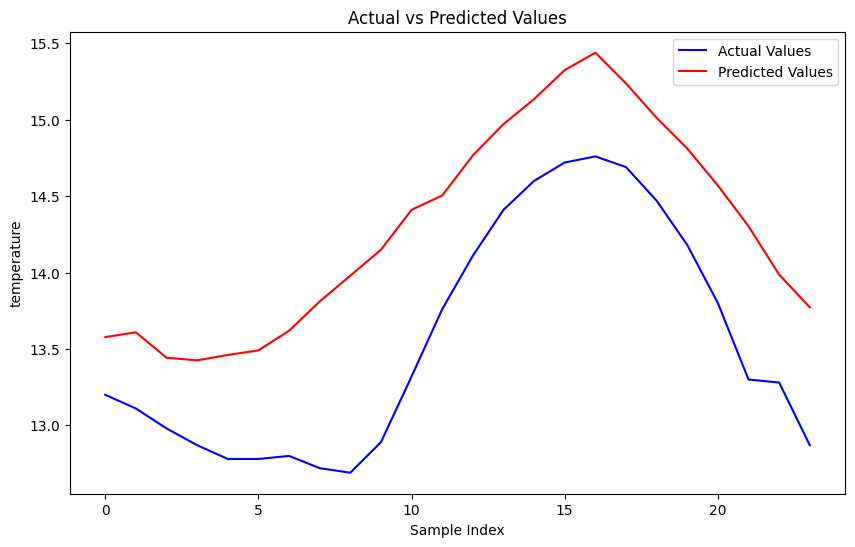

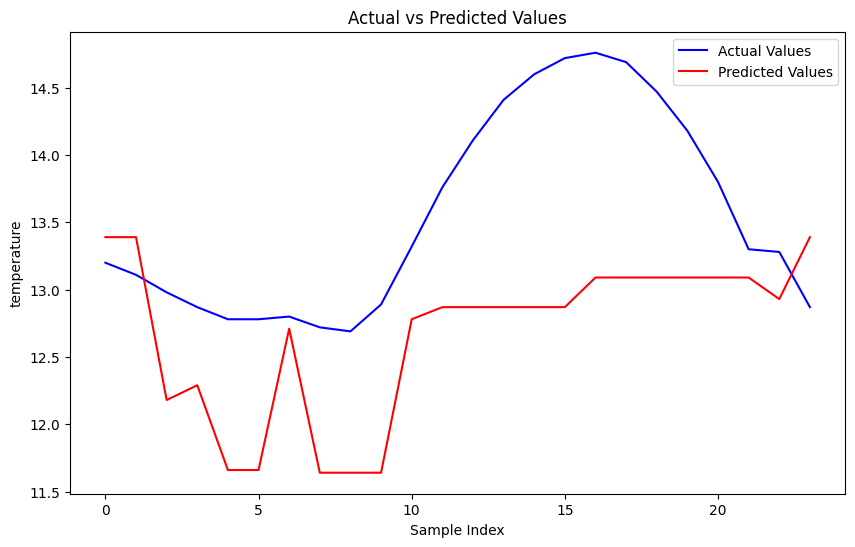

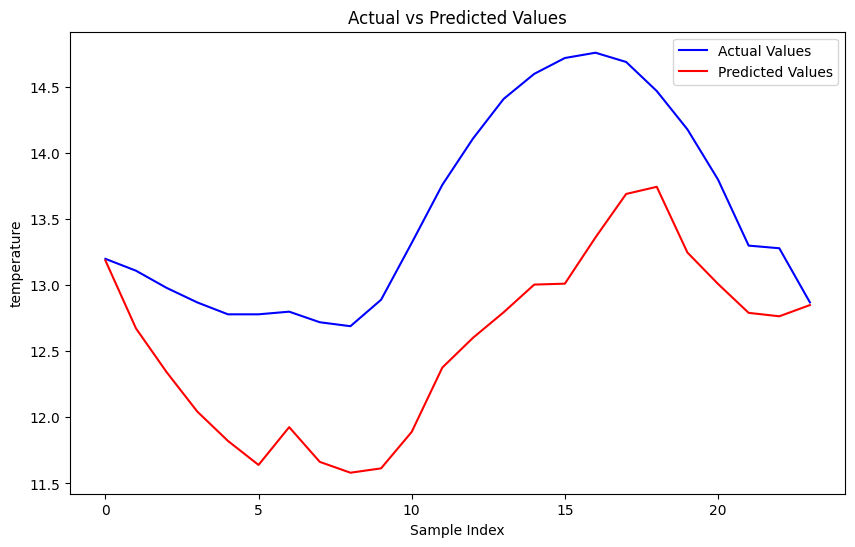

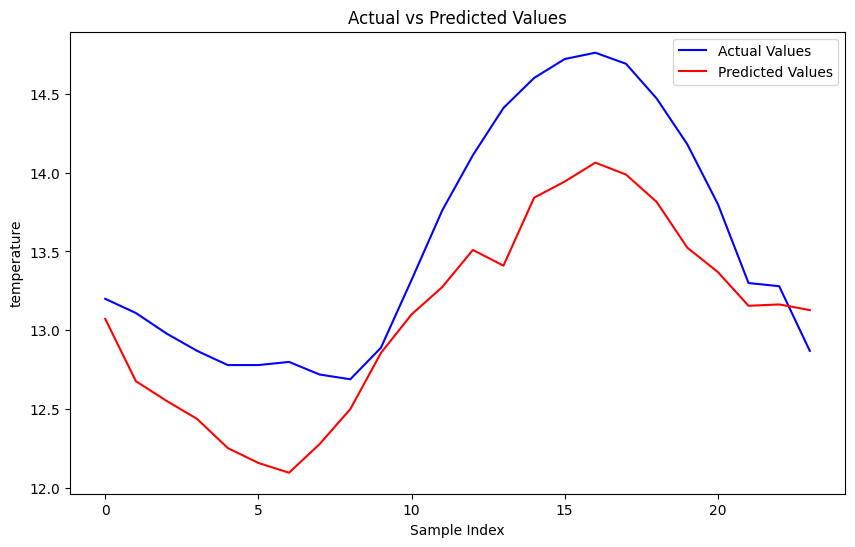

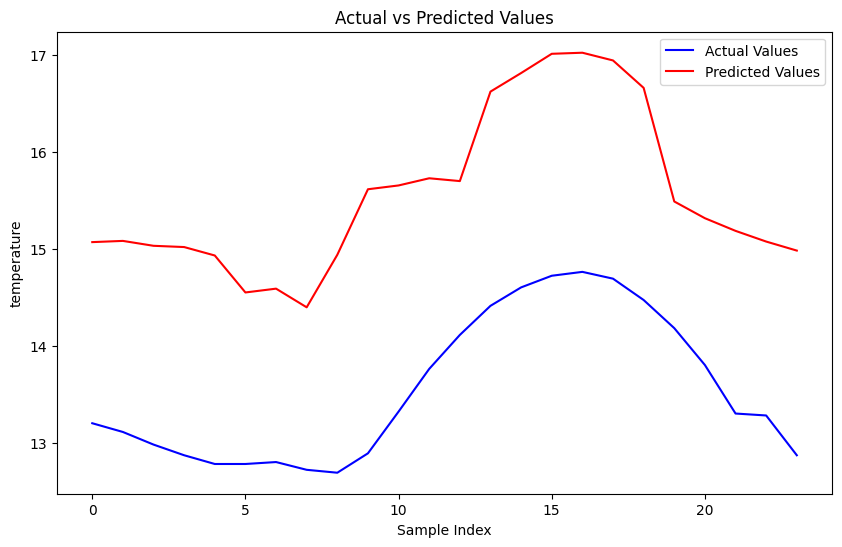

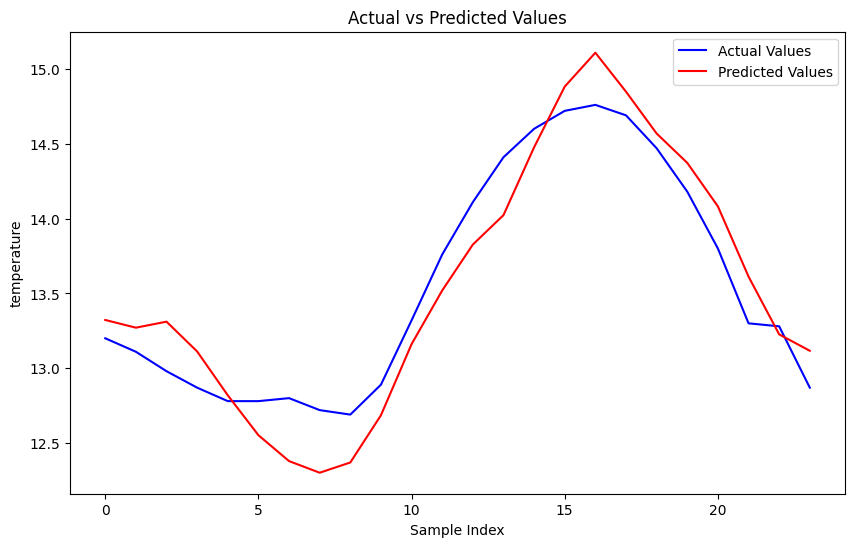

In [19]:
# Plotting
plt.figure(figsize=(10, 6))
plt.plot(y_test, label='Actual Values', color='blue')
plt.plot(y_pred_lm, label='Predicted Values', color='red')
plt.title('Actual vs Predicted Values')
plt.xlabel('Sample Index')
plt.ylabel(TARGET_COLUMN)
plt.legend()
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(y_test, label='Actual Values', color='blue')
plt.plot(y_pred_dt, label='Predicted Values', color='red')
plt.title('Actual vs Predicted Values')
plt.xlabel('Sample Index')
plt.ylabel(TARGET_COLUMN)
plt.legend()
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(y_test, label='Actual Values', color='blue')
plt.plot(y_pred_rf, label='Predicted Values', color='red')
plt.title('Actual vs Predicted Values')
plt.xlabel('Sample Index')
plt.ylabel(TARGET_COLUMN)
plt.legend()
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(y_test, label='Actual Values', color='blue')
plt.plot(y_pred_gb, label='Predicted Values', color='red')
plt.title('Actual vs Predicted Values')
plt.xlabel('Sample Index')
plt.ylabel(TARGET_COLUMN)
plt.legend()
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(y_test, label='Actual Values', color='blue')
plt.plot(y_pred_xg, label='Predicted Values', color='red')
plt.title('Actual vs Predicted Values')
plt.xlabel('Sample Index')
plt.ylabel(TARGET_COLUMN)
plt.legend()
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(y_test, label='Actual Values', color='blue')
plt.plot(y_pred_rnn, label='Predicted Values', color='red')
plt.title('Actual vs Predicted Values')
plt.xlabel('Sample Index')
plt.ylabel(TARGET_COLUMN)
plt.legend()
plt.show()


In [12]:
import numpy as np
import pandas as pd

# Function to create RNN sequences
def create_sequences(X, y, n_steps):
    Xs, ys = [], []
    for i in range(len(X) - n_steps):
        Xs.append(X.iloc[i:(i + n_steps)].values)
        ys.append(y.iloc[i + n_steps].values)
    return np.array(Xs), np.array(ys).reshape(-1, 1)



# Create sequences for RNN in the shape (samples, time steps, features)
n_steps = 5
X_train_seq, y_train_seq = create_sequences(X_train_df, y_train_df, n_steps)
X_test_seq, y_test_seq = create_sequences(X_test_df, y_test_df, n_steps)


NameError: name 'X_train_df' is not defined

In [ ]:
!pip install keras_tuner

In [ ]:
from keras.models import Sequential
from keras.layers import Dense, Flatten, LSTM
from keras.optimizers import Adam
import numpy as np
import time
import os
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras_tuner.engine.hyperparameters import HyperParameters
from keras_tuner import BayesianOptimization
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score


def build_rnn_model(hp):
    model = Sequential()
    model.add(LSTM(units=hp.Int('units', min_value=5, max_value=25, step=5),
                   input_shape=(X_train_seq.shape[1], X_train_seq.shape[2]),
                   return_sequences=True if hp.Int('num_layers', 2, 10) > 1 else False))
    for i in range(1, hp.Int('num_layers', 2, 10)):
        model.add(LSTM(units=hp.Int('units_' + str(i), 5, 25),
                       return_sequences=True if i < hp.Int('num_layers', 2, 10) - 1 else False))
    model.add(Dense(1))

    optimizer = Adam(learning_rate=hp.Float('learning_rate', 1e-7, 1e-2, sampling='log'))
    model.compile(optimizer=optimizer, loss='mean_squared_error')
    return model

hp = HyperParameters()
hp.Int('batch_size', 32, 132, step=10)

tuner = BayesianOptimization(
    build_rnn_model,
    objective='val_loss',
    max_trials=100,
    num_initial_points=20,
    project_name='rnn_tuning',
    hyperparameters=hp
)

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Start tuning
tuner.search(X_train_seq, y_train_seq, epochs=100, validation_split=0.1, verbose=1, callbacks=[early_stopping])

best_hps = tuner.get_best_hyperparameters()[0]

print("Best Hyperparameters:")
print(f"Units: {best_hps.get('units')}")
for i in range(best_hps.get('num_layers')):
    print(f"Units Layer {i}: {best_hps.get('units_' + str(i))}")
print(f"Learning Rate: {best_hps.get('learning_rate')}")
print(f"Batch Size: {best_hps.get('batch_size')}")

model_rnn = build_rnn_model(best_hps)
model_rnn.summary()

start_time_rnn = time.time()
model_rnn.fit(X_train_seq, y_train_seq, epochs=20, batch_size=best_hps.get('batch_size'), validation_split=0.1, verbose=1)
end_time_rnn = time.time()
training_time_rnn = end_time_rnn - start_time_rnn

# Assuming you have a function to calculate these metrics
y_pred_rnn = model_rnn.predict(X_test_seq)
y_pred_rnn = y_pred_rnn.flatten()
y_test_aligned = y_test[-len(y_pred_rnn):]

# Replace these with your metric calculation methods
mae_rnn = mean_absolute_error(y_test_aligned, y_pred_rnn)
mse_rnn = mean_squared_error(y_test_aligned, y_pred_rnn)
rmse_rnn = np.sqrt(mse_rnn)
mape_rnn = np.mean(np.abs((y_test_aligned - y_pred_rnn) / y_test_aligned)) * 100
mdape_rnn = np.median(np.abs((y_test_aligned - y_pred_rnn) / y_test_aligned)) * 100
r2_rnn = r2_score(y_test_aligned, y_pred_rnn)

metrics_df = metrics_df.append({
    'MODEL': 'rnn',
    'MAE': mae_rnn,
    'MSE': mse_rnn,
    'RMSE': rmse_rnn,
    'MAPE': mape_rnn,
    'MDAPE': mdape_rnn,
    'R2': r2_rnn,
    'Training_Length': len(y_train),
    'Testing_Length': len(y_test_aligned),
    'Training_Time': training_time_rnn
}, ignore_index=True)
print(metrics_df)


Trial 100 Complete [00h 00m 18s]
val_loss: 0.6139022707939148

Best val_loss So Far: 0.5304038524627686
Total elapsed time: 00h 59m 48s
Best Hyperparameters:
Units: 25


KeyError: 'units_0 does not exist.'

In [ ]:
print("Best Hyperparameters:")
print(f"Units (First Layer): {best_hps.get('units')}")

num_layers = best_hps.get('num_layers')
for i in range(1, num_layers):
    try:
        print(f"Units Layer {i}: {best_hps.get('units_' + str(i))}")
    except KeyError:
        # If the key doesn't exist, just break the loop
        break

print(f"Learning Rate: {best_hps.get('learning_rate')}")
print(f"Batch Size: {best_hps.get('batch_size')}")


Best Hyperparameters:
Units (First Layer): 25
Units Layer 1: 5
Units Layer 2: 25
Units Layer 3: 5
Units Layer 4: 22
Units Layer 5: 20
Units Layer 6: 25
Units Layer 7: 25
Units Layer 8: 5
Units Layer 9: 5
Learning Rate: 0.01
Batch Size: 132


Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_42 (LSTM)              (None, 5, 25)             3700      
                                                                 
 lstm_43 (LSTM)              (None, 5, 5)              620       
                                                                 
 dropout_16 (Dropout)        (None, 5, 5)              0         
                                                                 
 lstm_44 (LSTM)              (None, 5, 25)             3100      
                                                                 
 dropout_17 (Dropout)        (None, 5, 25)             0         
                                                                 
 lstm_45 (LSTM)              (None, 5, 5)              620       
                                                                 
 dropout_18 (Dropout)        (None, 5, 5)             

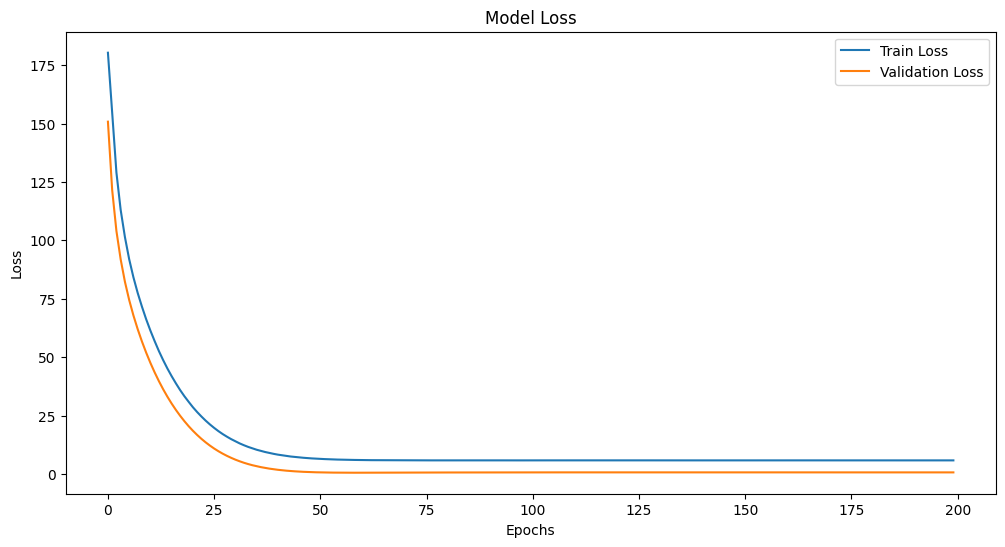

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from keras.layers import Dense, BatchNormalization, Input, LSTM, Dropout

# Define the optimal RNN model architecture
def build_optimal_rnn_model():
    model = Sequential()
    model.add(LSTM(units=25, input_shape=(X_train_seq.shape[1], X_train_seq.shape[2]), return_sequences=True))
    model.add(LSTM(units=5, return_sequences=True))
    model.add(Dropout(0.2))
    model.add(LSTM(units=25, return_sequences=True))
    model.add(Dropout(0.2))
    model.add(LSTM(units=5, return_sequences=True))
    model.add(Dropout(0.2))
    model.add(LSTM(units=22, return_sequences=True))
    model.add(Dropout(0.2))
    model.add(LSTM(units=20, return_sequences=True))
    model.add(Dropout(0.2))
    model.add(LSTM(units=25, return_sequences=True))
    model.add(Dropout(0.2))
    model.add(LSTM(units=25, return_sequences=True))
    model.add(Dropout(0.2))
    model.add(LSTM(units=5, return_sequences=True))
    model.add(Dropout(0.2))
    model.add(LSTM(units=5, return_sequences=False))
    model.add(Dense(1))

    optimizer = Adam(learning_rate=0.01)
    model.compile(optimizer=optimizer, loss='mean_squared_error')
    return model

# Build the model
optimal_model_rnn = build_optimal_rnn_model()

# Summarize the model
optimal_model_rnn.summary()

# Train the model
start_time_rnn = time.time()
history = optimal_model_rnn.fit(X_train_seq, y_train_seq, epochs=200, batch_size=132, validation_split=0.1, verbose=1)
end_time_rnn = time.time()
training_time_rnn = end_time_rnn - start_time_rnn

# Evaluate the model
y_pred_rnn = optimal_model_rnn.predict(X_test_seq)
y_pred_rnn = y_pred_rnn.flatten()
y_test_aligned = y_test[-len(y_pred_rnn):]

# Calculate metrics
mae_rnn = mean_absolute_error(y_test_aligned, y_pred_rnn)
mse_rnn = mean_squared_error(y_test_aligned, y_pred_rnn)
rmse_rnn = np.sqrt(mse_rnn)
mape_rnn = np.mean(np.abs((y_test_aligned - y_pred_rnn) / y_test_aligned)) * 100
mdape_rnn = np.median(np.abs((y_test_aligned - y_pred_rnn) / y_test_aligned)) * 100
r2_rnn = r2_score(y_test_aligned, y_pred_rnn)

# Plotting training and validation loss
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(loc='upper right')
plt.show()


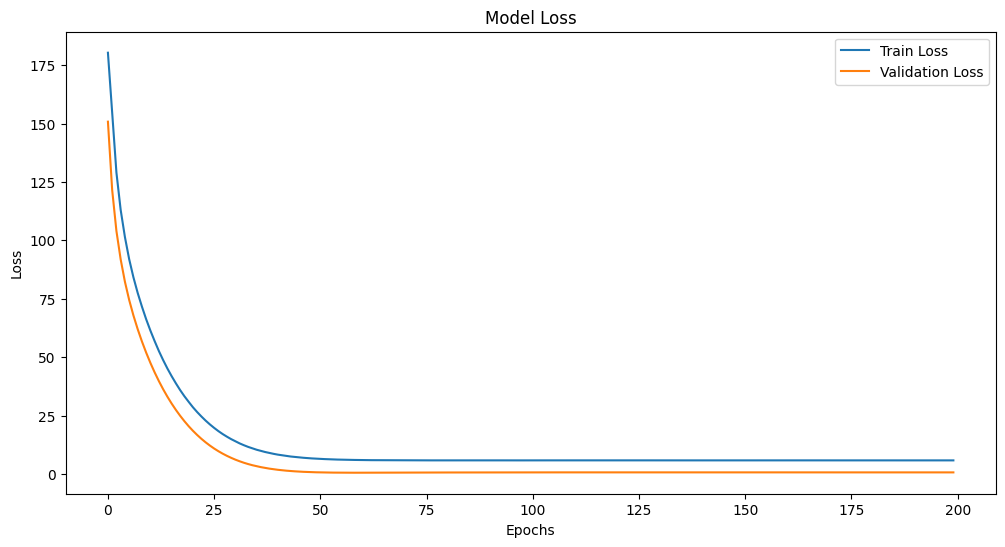

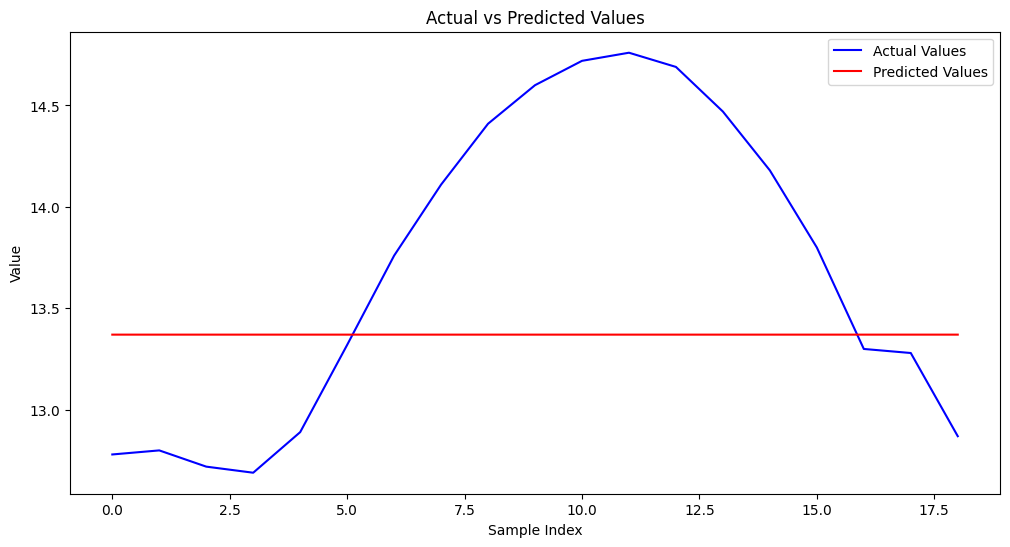

In [ ]:
# Continued from the previous code

# Plotting training and validation loss
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(loc='upper right')
plt.show()

# Plotting actual vs predictions with reset index
plt.figure(figsize=(12, 6))
plt.plot(range(len(y_test_aligned)), y_test_aligned, label='Actual Values', color='blue')
plt.plot(range(len(y_pred_rnn)), y_pred_rnn, label='Predicted Values', color='red')
plt.title('Actual vs Predicted Values')
plt.ylabel('Value')
plt.xlabel('Sample Index')
plt.legend(loc='upper right')
plt.show()


In [ ]:
import plotly.graph_objects as go
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout
from keras import optimizers
from keras.callbacks import EarlyStopping
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np


features = df.drop('target_column', axis=1)
target = df['target_column']

# Scale features
scaler = MinMaxScaler()
scaled_features = scaler.fit_transform(features)

# Define sequence_length
sequence_length = 4

X_train = []
y_train = []
for i in range(sequence_length, len(scaled_features)):
    X_train.append(scaled_features[i-sequence_length:i])
    y_train.append(target[i])

X_train, y_train = np.array(X_train), np.array(y_train)



# Define the new model architecture
model = Sequential([
    LSTM(100, return_sequences=True, input_shape=(sequence_length, scaled_features.shape[1])),
    Dropout(0.1),
    LSTM(100, return_sequences=True),
    Dropout(0.1),
    LSTM(100, return_sequences=False),
    Dropout(0.1),
    Dense(forecast_length)
])

# Compile the model
model.compile(optimizer=optimizers.Adam(learning_rate=0.001), loss='mse', metrics=['mae'])

# Early Stopping
early_stopping = EarlyStopping(monitor='val_loss', min_delta=0.0001, patience=6, verbose=1, mode='min')

# Fit the model
history = model.fit(X_train, y_train, epochs=25, validation_split=0.1, callbacks=[early_stopping], batch_size=32, verbose=1)

# Evaluate the model
test_loss, test_metric = model.evaluate(X_test, y_test, verbose=1)
print(f"Test Loss: {test_loss}")
print(f"Test MAE: {test_metric}")

# Predict and compare to actual values
last_sequence = X_test[-1].reshape((1, sequence_length, scaled_features.shape[1]))
predicted_temp = model.predict(last_sequence)
actual_temp = y_test[-1]

predicted_temperature_values = scaler_target.inverse_transform(predicted_temp.reshape(-1, 1))
actual_temperature = scaler_target.inverse_transform(actual_temp.reshape(-1, 1))

# Calculate metrics
rmse = np.sqrt(mean_squared_error(actual_temperature, predicted_temperature_values))
mae = mean_absolute_error(actual_temperature, predicted_temperature_values)
mape = np.mean(np.abs((actual_temperature - predicted_temperature_values) / actual_temp)) * 100

print(f"RMSE: {rmse}")
print(f"MAE: {mae}")
print(f"MAPE: {mape}")

# Plot predictions vs actual values
fig = go.Figure()

fig.add_trace(go.Scattergl(
    x=predicted_datetimes,
    y=actual_temperature.flatten(), mode='lines', name='Actual Temps'
))

fig.add_trace(go.Scattergl(
    x=predicted_datetimes,
    y=predicted_temperature_values.flatten(), mode='lines', name='Predicted Temps'
))

fig.update_layout(title='Predictions vs Actual Values',
                  xaxis_title='Date',
                  yaxis_title='Temperature')
fig.show()


NameError: name 'scaled_features' is not defined

In [ ]:
!pip install keras_tuner
from keras.models import Sequential
from keras.layers import LSTM, Dense
from keras.optimizers import Adam
import numpy as np
import time
from sklearn.preprocessing import MinMaxScaler
from keras_tuner import BayesianOptimization
from keras_tuner.engine.hyperparameters import HyperParameters
from keras.callbacks import EarlyStopping, ModelCheckpoint
import os
import pandas as pd

# Mount Google Drive (if you are using Google Colab)
from google.colab import drive
drive.mount('/content/drive')


# Load data
TrainData_location = '/content/drive/MyDrive/Data/df_all_600_Processed.csv'
df_train = pd.read_csv(TrainData_location)

TestData_location = '/content/drive/MyDrive/Data/SWIFT_LF_301.csv'
df_test = pd.read_csv(TestData_location)
df_test = df_test[df_train.columns]

TARGET_COLUMN = 'V_SFP_gpl_Soot_Load_Comb_avg'

X_train = df_train.drop(TARGET_COLUMN, axis=1)
y_train = df_train[TARGET_COLUMN]

X_test = df_test.drop(TARGET_COLUMN, axis=1)
y_test = df_test[TARGET_COLUMN]  # Fixed line, it should be y_test instead of y_train

scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


# Function to create RNN sequences:
def create_sequences(X, y, n_steps):
    Xs, ys = [], []
    for i in range(len(X) - n_steps):
        Xs.append(X[i:(i + n_steps)])
        ys.append(y[i + n_steps])
    return np.array(Xs), np.array(ys).reshape(-1, 1)

# Create sequences for RNN
n_steps = 5  # Adjust this based on your dataset
X_train_seq, y_train_seq = create_sequences(X_train, y_train, n_steps)
X_valid_seq, y_valid_seq = create_sequences(X_test, y_test, n_steps)


# Directory where model checkpoints will be saved
checkpoint_dir = '/content/drive/MyDrive/Data/TuningRNN'
os.makedirs(checkpoint_dir, exist_ok=True)

# Checkpoint callback to save the model after every epoch
checkpoint_callback = ModelCheckpoint(
    filepath=os.path.join(checkpoint_dir, 'model_{epoch:02d}-{val_loss:.2f}.h5'),
    save_weights_only=False,
    monitor='val_loss',
    save_best_only=True,
    verbose=1
)

# Make sure your X_train_seq and X_valid_seq are already in the shape (samples, time steps, features)

def build_rnn_model(hp):
    model = Sequential()
    model.add(LSTM(units=hp.Int('units', min_value=5, max_value=25, step=5),
                   input_shape=(X_train_seq.shape[1], X_train_seq.shape[2]),
                   return_sequences=True if hp.Int('num_layers', 2, 10) > 1 else False))
    for i in range(1, hp.Int('num_layers', 2, 10)):
        model.add(LSTM(units=hp.Int('units_' + str(i), 5, 25),
                       return_sequences=True if i < hp.Int('num_layers', 2, 10) - 1 else False))
    model.add(Dense(1))

    optimizer = Adam(learning_rate=hp.Float('learning_rate', 1e-7, 1e-2, sampling='log'))
    model.compile(optimizer=optimizer, loss='mean_squared_error')
    return model

hp = HyperParameters()
hp.Int('batch_size', 32, 132, step=10)

tuner = BayesianOptimization(
    build_rnn_model,
    objective='val_loss',
    max_trials=100,
    num_initial_points=20,
    project_name='rnn_tuning',
    hyperparameters=hp
)

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Start tuning
tuner.search(X_train_seq, y_train_seq, epochs=100, validation_split=0.1, verbose=1, callbacks=[early_stopping, checkpoint_callback])

best_hps = tuner.get_best_hyperparameters()[0]

print("Best Hyperparameters:")
print(f"Units: {best_hps.get('units')}")
for i in range(best_hps.get('num_layers')):
    print(f"Units Layer {i}: {best_hps.get('units_' + str(i))}")
print(f"Learning Rate: {best_hps.get('learning_rate')}")
print(f"Batch Size: {best_hps.get('batch_size')}")

model_rnn = build_rnn_model(best_hps)
model_rnn.summary()

start_time_rnn = time.time()
model_rnn.fit(X_train_seq, y_train_seq, epochs=20, batch_size=best_hps.get('batch_size'), validation_split=0.1, verbose=1)
end_time_rnn = time.time()
training_time_rnn = end_time_rnn - start_time_rnn

# Assuming you have a function to calculate these metrics
y_pred_rnn = model_rnn.predict(X_valid_seq)
y_pred_rnn = y_pred_rnn.flatten()
y_test_aligned = y_test[-len(y_pred_rnn):]

# Replace these with your metric calculation methods
mae_rnn = mean_absolute_error(y_test_aligned, y_pred_rnn)
mse_rnn = mean_squared_error(y_test_aligned, y_pred_rnn)
rmse_rnn = np.sqrt(mse_rnn)
mape_rnn = np.mean(np.abs((y_test_aligned - y_pred_rnn) / y_test_aligned)) * 100
mdape_rnn = np.median(np.abs((y_test_aligned - y_pred_rnn) / y_test_aligned)) * 100
r2_rnn = r2_score(y_test_aligned, y_pred_rnn)

metrics_df = metrics_df.append({
    'MODEL': 'rnn',
    'MAE': mae_rnn,
    'MSE': mse_rnn,
    'RMSE': rmse_rnn,
    'MAPE': mape_rnn,
    'MDAPE': mdape_rnn,
    'R2': r2_rnn,
    'Training_Length': len(y_train),
    'Testing_Length': len(y_test_aligned),
    'Training_Time': training_time_rnn
}, ignore_index=True)
print(metrics_df)
